# Importações

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Leitura dataset e pré-processamento

In [27]:
global dataset
global dataset_original

def load_dataset(name='dataset-unificado.csv'):
    global dataset
    global dataset_original
    
    dataset = pd.read_csv(name, sep=';')
    dataset_original = dataset
    
def under_sampling(sampling_strategy={1:800, 2:320}):
    global dataset
    global dataset_original
    
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={0:0, 1:299, 2:900, 3:826, 4:458, 5:233})
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={0:0, 1:454, 2:970, 3:717, 4:458, 5:204})
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={1:800, 2:520})
    rus = RandomUnderSampler(random_state=0, sampling_strategy=sampling_strategy)
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={1:700, 2:270, 3:692})
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={1:655, 2:229, 3:648})
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={1:454})
    X_res, y_res = rus.fit_resample(
            pd.DataFrame(dataset.index.array)[0].values.reshape(-1,1), 
            dataset['Cyclomatic'].values
    )
    
    dataset['idx'] = dataset.index
    idx_selected = X_res.reshape(1,-1)[0]
    dataset['selected'] = dataset['idx'].apply(lambda idx: idx in idx_selected)
    dataset = dataset[dataset['selected']]
    dataset = dataset.drop('idx', axis=1)
    dataset = dataset.drop('selected', axis=1)
    
def remove_last_column():
    global dataset
    
    dataset = dataset.iloc[:,:-1]
    
def remove_nan():
    global dataset
    
    dataset = dataset.dropna()
    
def fix_coverage_metrics():
    global dataset
    
    dataset.iloc[:,-1] = dataset.iloc[:,-1].apply(lambda ppc: float(ppc.replace(',', '.')) if type(ppc) == str else ppc)
    dataset.iloc[:,-2] = dataset.iloc[:,-2].apply(lambda ec: float(ec.replace(',', '.')) if type(ec) == str else ppc)
    dataset_original['PrimePathCoverage'] = dataset_original['PrimePathCoverage'].apply(lambda ppc: float(ppc.replace(',', '.')) if type(ppc) == str else ppc)
    dataset_original['EdgeCoverage'] = dataset_original['EdgeCoverage'].apply(lambda ec: float(ec.replace(',', '.')) if type(ec) == str else ppc)
    
def remove_coverage_metrics_with_zero():
    global dataset
    
    dataset = dataset[(dataset['EdgeCoverage'] != 0) | (dataset['PrimePathCoverage'] != 0)]
    #dataset = dataset[dataset['PrimePathCoverage'] > 0]
    
def select_metrics(metrics):
    global dataset
    
    dataset = dataset[metrics]
    
def remove_ppc_greater_than_ec():
    global dataset
    
    dataset = dataset[(dataset['PrimePathCoverage'] <= dataset['EdgeCoverage'])]
    
def remove_ppc_between(start, end):
    global dataset
    
    dataset = dataset[(dataset['PrimePathCoverage'] < start) | (dataset['PrimePathCoverage'] > end)]

In [28]:
original_metrics = [
    # Método testado
    'Name','CountInput','CountLine','CountLineBlank','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage','PrimePathCoverage',
    
    # Método de teste
    'Name.1','CountInput.1','CountLine.1','CountLineBlank.1','CountLineCode.1','CountLineCodeDecl.1',
    'CountLineCodeExe.1','CountLineComment.1','CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticModified.1','CyclomaticStrict.1','Essential.1',
    'Knots.1','MaxEssentialKnots.1','MaxNesting.1','MinEssentialKnots.1',
]

selected_metrics = [
    # Método testado
    'Name','CountInput','CountLineCode',
    'CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticStrict',
    'Knots','MaxNesting','EdgeCoverage','PrimePathCoverage',
    
    # Método de teste
    'Name.1','CountLineCode.1',
    'CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticStrict.1'
]

In [29]:
load_dataset()
remove_last_column()
remove_nan()
fix_coverage_metrics()
#remove_coverage_metrics_with_zero()
#under_sampling({1:1300})
under_sampling({1:946, 2:720, 3:670})
select_metrics(selected_metrics)
remove_ppc_greater_than_ec()
remove_ppc_between(0.90, 0.99)

Dataset size:  3681
Média complexidade dataset balanceado:  4.005433306166802


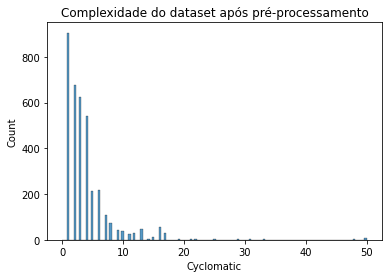

In [9]:
print('Dataset size: ', dataset.shape[0])
print('Média complexidade dataset balanceado: ', dataset['Cyclomatic'].mean())
plt.title("Complexidade do dataset após pré-processamento")
sns.histplot(dataset['Cyclomatic'])
plt.show()

# Características do dataset original

[Text(0.5, 0, 'Total'), Text(0, 0.5, 'Cyclomatic')]

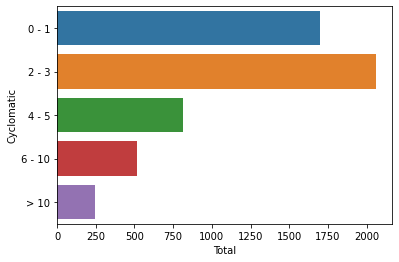

In [10]:
def get_level_of_cyclomatic(level):
    if level <= 1:
        return '0 - 1'
    elif level <= 3:
        return '2 - 3'
    elif level <= 5:
        return '4 - 5'
    elif level <= 10:
        return '6 - 10'

    return '> 10'

d_tmp = dataset_original
d_tmp['Cyclomatic_Level'] = dataset_original['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 1', '2 - 3', '4 - 5', '6 - 10', '> 10'])
ax.set(xlabel='Total', ylabel='Cyclomatic')

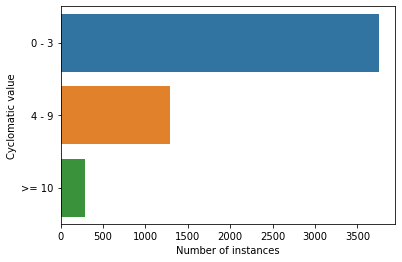

In [927]:
def get_level_of_cyclomatic(level):
    if level <= 3:
        return '0 - 3'
    elif level <= 9:
        return '4 - 9'

    return '>= 10'


d_tmp = dataset_original
d_tmp['Cyclomatic_Level'] = dataset_original['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 3', '4 - 9', '>= 10'])
ax.set(xlabel='Number of instances', ylabel='Cyclomatic value')
plt.savefig('cyclomatic-chart-noprocessing.png', dpi=300)

[Text(0.5, 0, 'Total'), Text(0, 0.5, 'Cyclomatic')]

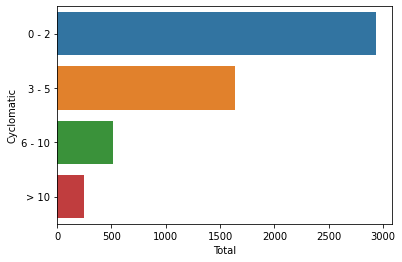

In [928]:
def get_level_of_cyclomatic(level):
    if level <= 2:
        return '0 - 2'
    elif level <= 5:
        return '3 - 5'
    elif level <= 10:
        return '6 - 10'

    return '> 10'

d_tmp = dataset_original
d_tmp['Cyclomatic_Level'] = dataset_original['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 2', '3 - 5', '6 - 10', '> 10'])
ax.set(xlabel='Total', ylabel='Cyclomatic')

Dataset size:  5342
Média complexidade dataset:  3.3569824035941593


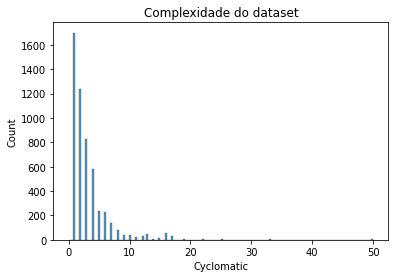

In [929]:
print('Dataset size: ', dataset_original.shape[0])
print('Média complexidade dataset: ', dataset_original['Cyclomatic'].mean())
plt.title("Complexidade do dataset")
sns.histplot(dataset_original['Cyclomatic'])
plt.show()

<AxesSubplot:title={'center':'Contribuição de cada projeto no dataset após pré-processamento'}, xlabel='count', ylabel='Project'>

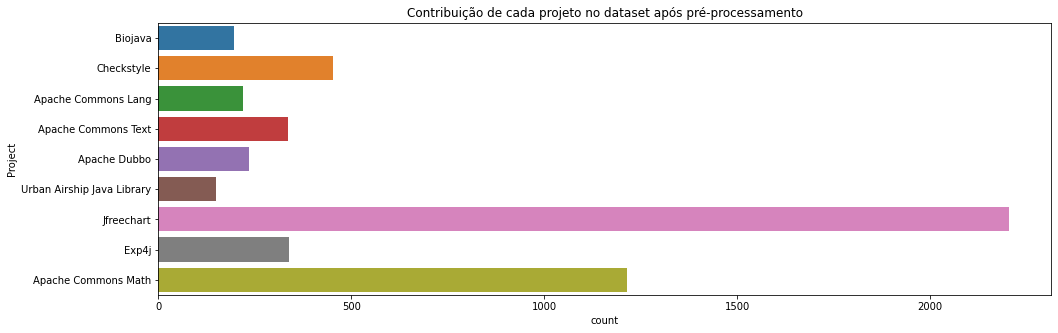

In [930]:
def signature_to_project(signature):
    project = ''
    
    if 'com.puppycrawl.tools.checkstyle' in signature:
        project = 'Checkstyle'
    elif 'exp4j' in signature:
        project = 'Exp4j'
    elif 'biojava' in signature:
        project = 'Biojava'
    elif 'org.jfree' in signature:
        project = 'Jfreechart'
    elif 'com.urbanairship' in signature:
        project = 'Urban Airship Java Library'
    elif 'org.apache.commons.text' in signature:
        project = 'Apache Commons Text'
    elif 'dubbo' in signature:
        project = 'Apache Dubbo'
    elif 'org.apache.commons.lang3' in signature:
        project = 'Apache Commons Lang'
    elif 'math3' in signature:
        project = 'Apache Commons Math'
        
    return project

d2 = dataset_original
d2['Project'] = dataset_original['Name'].apply(signature_to_project)
plt.figure(figsize=(16,5))
plt.title("Contribuição de cada projeto no dataset após pré-processamento")

contrib_projetos = d2.groupby('Project')
contrib_projetos = contrib_projetos.count()

sns.countplot(y='Project', data=d2, orient='h')

<AxesSubplot:title={'center':'Correlação das métricas'}>

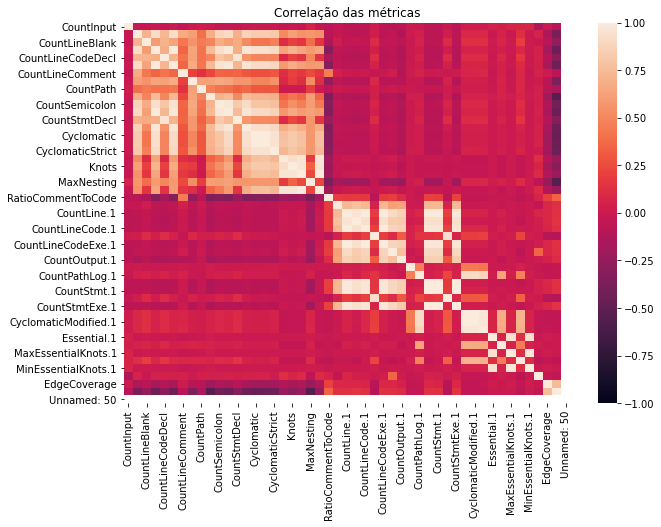

In [931]:
plt.figure(figsize=(10,7))
plt.title("Correlação das métricas")
sns.heatmap(dataset_original.corr(), vmin=-1, vmax=1)

<AxesSubplot:title={'center':'Contribuição de cada projeto no dataset após pré-processamento'}, xlabel='count', ylabel='Project'>

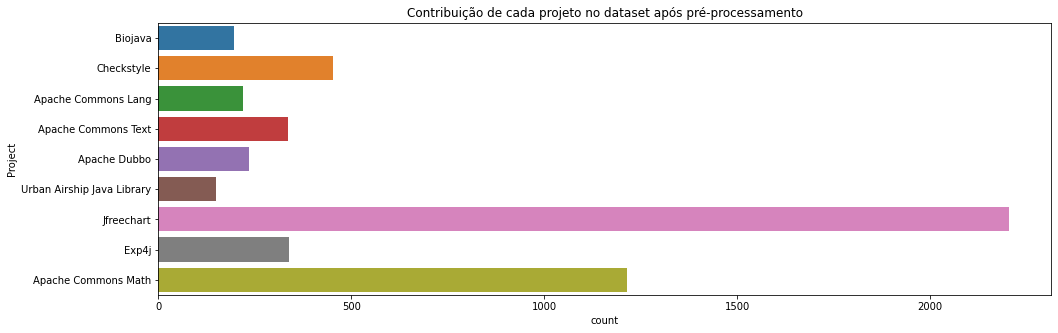

In [932]:
def signature_to_project(signature):
    project = ''
    
    if 'com.puppycrawl.tools.checkstyle' in signature:
        project = 'Checkstyle'
    elif 'exp4j' in signature:
        project = 'Exp4j'
    elif 'biojava' in signature:
        project = 'Biojava'
    elif 'org.jfree' in signature:
        project = 'Jfreechart'
    elif 'com.urbanairship' in signature:
        project = 'Urban Airship Java Library'
    elif 'org.apache.commons.text' in signature:
        project = 'Apache Commons Text'
    elif 'dubbo' in signature:
        project = 'Apache Dubbo'
    elif 'org.apache.commons.lang3' in signature:
        project = 'Apache Commons Lang'
    elif 'math3' in signature:
        project = 'Apache Commons Math'
        
    return project

d2 = dataset_original
d2['Project'] = dataset_original['Name'].apply(signature_to_project)
plt.figure(figsize=(16,5))
plt.title("Contribuição de cada projeto no dataset após pré-processamento")

contrib_projetos = d2.groupby('Project')
contrib_projetos = contrib_projetos.count()

sns.countplot(y='Project', data=d2, orient='h')

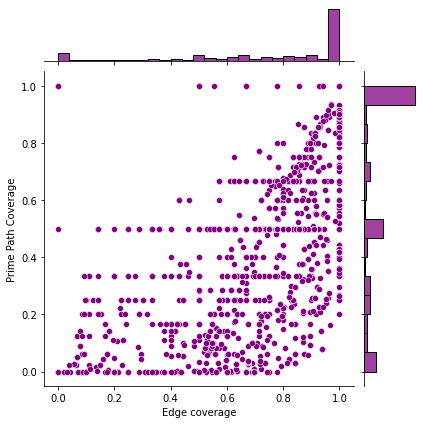

In [933]:
ax = sns.jointplot(x='EdgeCoverage', y='PrimePathCoverage', data=dataset_original, kind='scatter', color='purple')
ax.set_axis_labels('Edge coverage', 'Prime Path Coverage')
plt.show(ax)

# Características do dataset após pré-processamento

In [1140]:
print('Repeated registers:', dataset[dataset.duplicated()].shape[0])

Repeated registers: 0


[Text(0.5, 0, 'Total'), Text(0, 0.5, 'Cyclomatic')]

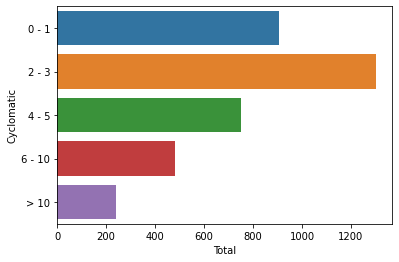

In [364]:
def get_level_of_cyclomatic(level):
    if level <= 1:
        return '0 - 1'
    elif level <= 3:
        return '2 - 3'
    elif level <= 5:
        return '4 - 5'
    elif level <= 10:
        return '6 - 10'

    #elif level <= 20:
    #    return '16 - 20'
    
    return '> 10'


d_tmp = dataset
d_tmp['Cyclomatic_Level'] = dataset['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 1', '2 - 3', '4 - 5', '6 - 10', '> 10'])
ax.set(xlabel='Total', ylabel='Cyclomatic')

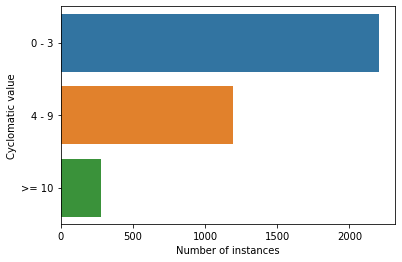

In [365]:
def get_level_of_cyclomatic(level):
    if level <= 3:
        return '0 - 3'
    elif level <= 9:
        return '4 - 9'

    return '>= 10'


d_tmp = dataset
d_tmp['Cyclomatic_Level'] = dataset['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 3', '4 - 9', '>= 10'])
ax.set(xlabel='Number of instances', ylabel='Cyclomatic value')
plt.savefig('cyclomatic-chart-preprocessing.png', dpi=300)

[Text(0.5, 0, 'Total'), Text(0, 0.5, 'Cyclomatic')]

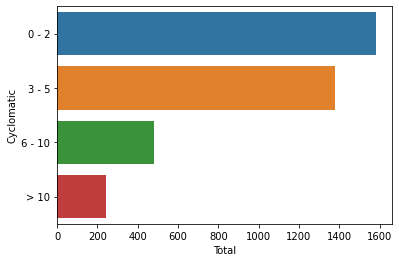

In [366]:
def get_level_of_cyclomatic(level):
    if level <= 2:
        return '0 - 2'
    elif level <= 5:
        return '3 - 5'
    elif level <= 10:
        return '6 - 10'

    return '> 10'

d_tmp = dataset
d_tmp['Cyclomatic_Level'] = dataset['Cyclomatic'].apply(lambda value: get_level_of_cyclomatic(value))
d_tmp_groupby = d_tmp.groupby('Cyclomatic_Level').count()#['Cyclomatic']
d_tmp_groupby['Level'] = d_tmp_groupby.index.values
#d_tmp_groupby.sort_values()
ax = sns.barplot(x='Cyclomatic', y='Level', data=d_tmp_groupby, orient='h', order=['0 - 2', '3 - 5', '6 - 10', '> 10'])
ax.set(xlabel='Total', ylabel='Cyclomatic')

Dataset size:  3681
Média complexidade dataset balanceado:  4.005433306166802


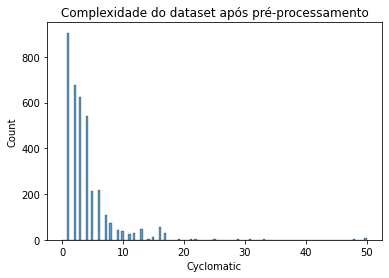

In [367]:
print('Dataset size: ', dataset.shape[0])
print('Média complexidade dataset balanceado: ', dataset['Cyclomatic'].mean())
plt.title("Complexidade do dataset após pré-processamento")
sns.histplot(dataset['Cyclomatic'])
plt.show()

<AxesSubplot:title={'center':'Contribuição de cada projeto no dataset após pré-processamento'}, xlabel='count', ylabel='Project'>

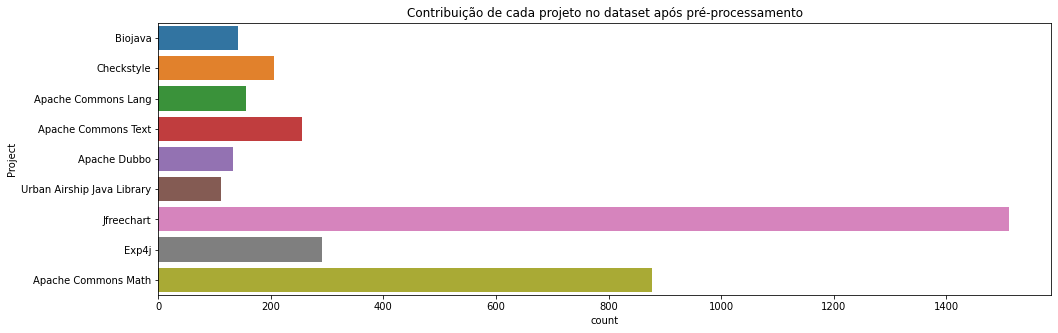

In [12]:
def signature_to_project(signature):
    project = ''
    
    if 'com.puppycrawl.tools.checkstyle' in signature:
        project = 'Checkstyle'
    elif 'exp4j' in signature:
        project = 'Exp4j'
    elif 'biojava' in signature:
        project = 'Biojava'
    elif 'org.jfree' in signature:
        project = 'Jfreechart'
    elif 'com.urbanairship' in signature:
        project = 'Urban Airship Java Library'
    elif 'org.apache.commons.text' in signature:
        project = 'Apache Commons Text'
    elif 'dubbo' in signature:
        project = 'Apache Dubbo'
    elif 'org.apache.commons.lang3' in signature:
        project = 'Apache Commons Lang'
    elif 'math3' in signature:
        project = 'Apache Commons Math'
        
    return project

d2 = dataset
d2['Project'] = dataset['Name'].apply(signature_to_project)
plt.figure(figsize=(16,5))
plt.title("Contribuição de cada projeto no dataset após pré-processamento")

contrib_projetos = d2.groupby('Project')
contrib_projetos = contrib_projetos.count()

sns.countplot(y='Project', data=d2, orient='h')

<AxesSubplot:title={'center':'Complexidade do dataset após pré-processamento por projeto'}, xlabel='count', ylabel='Project'>

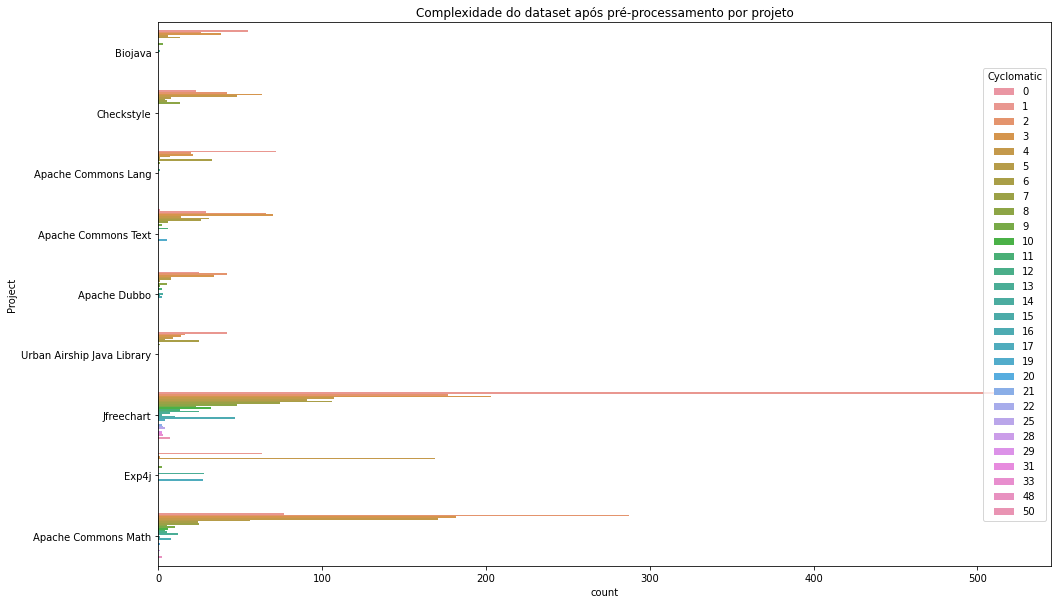

In [369]:
plt.figure(figsize=(16,10))
plt.title('Complexidade do dataset após pré-processamento por projeto')
sns.countplot(y='Project', data=d2, orient='h', hue='Cyclomatic')

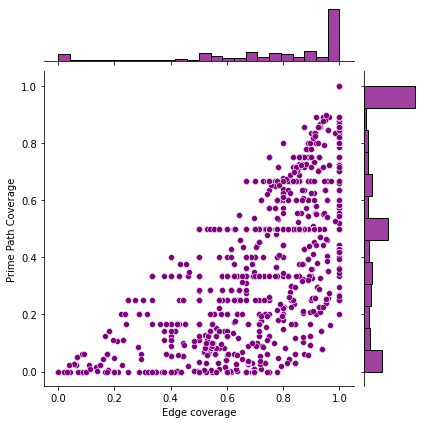

In [370]:
ax = sns.jointplot(x='EdgeCoverage', y='PrimePathCoverage', data=dataset, kind='scatter', color='purple')
ax.set_axis_labels('Edge coverage', 'Prime Path Coverage')
plt.savefig('ec-ppc.png', dpi=300)
plt.show(ax)

<AxesSubplot:title={'center':'Correlação das métricas após pré-processamento'}>

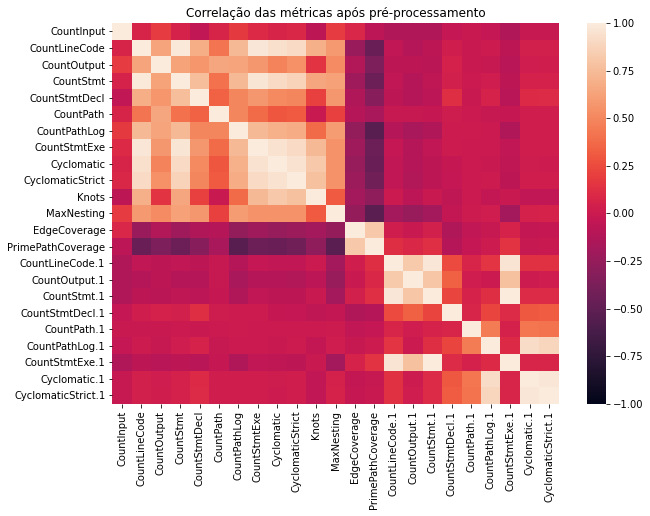

In [371]:
plt.figure(figsize=(10,7))
plt.title("Correlação das métricas após pré-processamento")
sns.heatmap(dataset.corr(), vmin=-1, vmax=1)

,Metrics,Correlation
12,EdgeCoverage,0.816491
19,CountStmtExe.1,0.142334
15,CountStmt.1,0.125417
13,CountLineCode.1,0.118900
14,CountOutput.1,0.086368
18,CountPathLog.1,0.002803
21,CyclomaticStrict.1,-0.014291
20,Cyclomatic.1,-0.018177
17,CountPath.1,-0.033461
0,CountInput,-0.076267


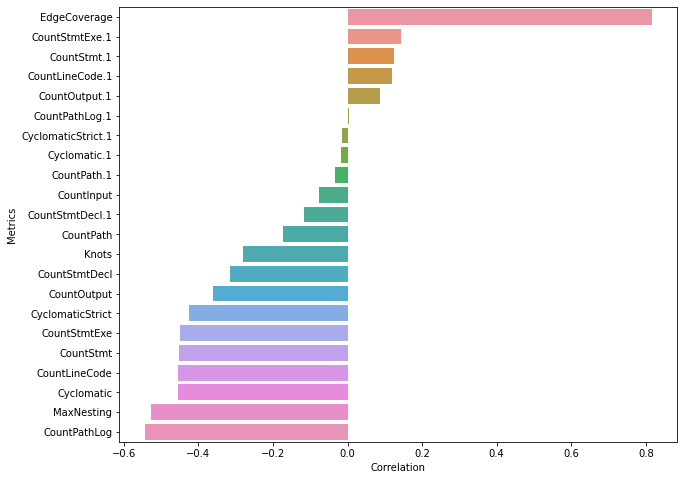

In [372]:
correlations = dataset.corr()['PrimePathCoverage']
correlations = correlations.drop('PrimePathCoverage')

metrics = correlations.index
ppc_corr = correlations.values
corr_table = pd.DataFrame(columns=['Metrics', 'Correlation'])
corr_table['Metrics'] = metrics
corr_table['Correlation'] = ppc_corr
corr_table = corr_table.sort_values(ascending=False, by='Correlation')

plt.figure(figsize=(10,8))
sns.barplot(y='Metrics', x='Correlation', data=corr_table)

display(corr_table)

In [13]:
d_groupby = d2.groupby('Project')
d_groupby['Cyclomatic'].describe()

,count,mean,std,min,25%,50%,75%,max
Project,,,,,,,,
Apache Commons Lang,156.0,2.730769,2.141287,1.0,1.0,2.0,4.0,12.0
Apache Commons Math,877.0,3.668187,3.431396,1.0,2.0,3.0,4.0,48.0
Apache Commons Text,256.0,3.746094,2.972090,0.0,2.0,3.0,5.0,19.0
Apache Dubbo,132.0,3.401515,3.154688,1.0,2.0,2.0,3.0,16.0
Biojava,142.0,2.464789,1.828312,1.0,1.0,2.0,3.0,13.0
Checkstyle,206.0,3.354369,1.751837,1.0,2.0,3.0,4.0,8.0
Exp4j,290.0,5.458621,4.862114,1.0,4.0,4.0,4.0,17.0
Jfreechart,1511.0,4.459960,5.395198,1.0,1.0,3.0,6.0,50.0
Urban Airship Java Library,111.0,2.972973,2.042545,1.0,1.0,2.0,5.0,8.0


In [35]:
d_groupby = d2.groupby('Project')
d_tmp = d_groupby['CountLineCode'].describe()
d_tmp['sum'] = d_groupby['CountLineCode'].sum()
d_tmp

,count,mean,std,min,25%,50%,75%,max,sum
Project,,,,,,,,,
Apache Commons Lang,156.0,9.775641,7.507909,4.0,4.0,6.0,12.0,49.0,1525
Apache Commons Math,877.0,16.077537,17.892459,4.0,7.0,11.0,17.0,225.0,14100
Apache Commons Text,256.0,14.148438,12.634897,1.0,7.0,13.0,18.0,86.0,3622
Apache Dubbo,132.0,13.030303,12.059610,4.0,7.0,8.0,14.0,61.0,1720
Biojava,142.0,11.366197,11.055295,4.0,4.0,9.0,13.0,85.0,1614
Checkstyle,206.0,14.946602,8.113948,4.0,10.0,13.0,17.0,40.0,3079
Exp4j,290.0,19.562069,14.309648,4.0,16.0,16.0,16.0,48.0,5673
Jfreechart,1511.0,18.007280,20.782840,4.0,5.0,12.0,22.0,171.0,27209
Urban Airship Java Library,111.0,10.954955,7.141922,4.0,4.0,9.0,16.0,23.0,1216


In [1152]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4046 entries, 0 to 5340
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                4046 non-null   object 
 1   CountInput          4046 non-null   int64  
 2   CountLineCode       4046 non-null   int64  
 3   CountOutput         4046 non-null   int64  
 4   CountStmt           4046 non-null   int64  
 5   CountStmtDecl       4046 non-null   int64  
 6   CountPath           4046 non-null   int64  
 7   CountPathLog        4046 non-null   int64  
 8   CountStmtExe        4046 non-null   int64  
 9   Cyclomatic          4046 non-null   int64  
 10  CyclomaticStrict    4046 non-null   int64  
 11  Knots               4046 non-null   int64  
 12  MaxNesting          4046 non-null   int64  
 13  EdgeCoverage        4046 non-null   float64
 14  PrimePathCoverage   4046 non-null   float64
 15  Name.1              4046 non-null   object 
 16  CountL

In [1153]:
dataset.describe()

,CountInput,CountLineCode,CountOutput,CountStmt,CountStmtDecl,CountPath,CountPathLog,CountStmtExe,Cyclomatic,CyclomaticStrict,...,PrimePathCoverage,CountLineCode.1,CountOutput.1,CountStmt.1,CountStmtDecl.1,CountPath.1,CountPathLog.1,CountStmtExe.1,Cyclomatic.1,CyclomaticStrict.1
count,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,...,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000
mean,22.466387,15.351211,5.390262,10.877410,2.961691,65.404103,0.473554,7.915719,3.766930,4.265447,...,0.619916,23.134207,9.707118,18.627533,4.422392,396.766930,0.083786,14.205141,1.404597,1.421898
std,39.676463,16.906695,4.965761,11.620441,3.618694,623.212835,0.675305,9.159057,4.196567,5.094919,...,0.362580,32.446400,8.965253,28.251063,3.230461,14275.007009,0.372277,27.780028,1.226880,1.281881
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,5.000000,6.000000,3.000000,4.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,...,0.333300,9.000000,5.000000,7.000000,3.000000,1.000000,0.000000,3.000000,1.000000,1.000000
50%,9.000000,11.000000,4.000000,7.000000,2.000000,3.000000,0.000000,5.000000,3.000000,3.000000,...,0.636400,14.000000,7.000000,11.000000,3.000000,1.000000,0.000000,6.000000,1.000000,1.000000
75%,20.000000,17.000000,7.000000,13.000000,3.000000,6.000000,1.000000,10.000000,4.000000,5.000000,...,1.000000,23.000000,11.000000,19.000000,5.000000,1.000000,0.000000,13.000000,1.000000,1.000000
max,201.000000,225.000000,58.000000,144.000000,49.000000,12240.000000,4.000000,99.000000,50.000000,72.000000,...,1.000000,273.000000,70.000000,230.000000,32.000000,524288.000000,6.000000,226.000000,20.000000,20.000000


# Funções uteis

In [412]:
k = 10
metricas_erro = [
    'r2', 'max_error', 'neg_mean_absolute_error',
    'neg_mean_squared_error', 'neg_root_mean_squared_error',
    'neg_mean_squared_log_error', 'neg_median_absolute_error'
]
previsores = [
    # Método testado
    'CountInput','CountLineCode',
    'CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticStrict',
    'Knots','MaxNesting','EdgeCoverage',
    
    # Método de teste
    'CountLineCode.1',
    'CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticStrict.1'
]

previsores_sem_ec = previsores.copy()
previsores_sem_ec.remove('EdgeCoverage')

In [413]:
def feature_importance_of(regressor_model, previsores, ppc, previsores_nome):
    results = permutation_importance(regressor_model, previsores, ppc, scoring='neg_mean_squared_error')  
    importance = results.importances_mean

    return importance

In [414]:
def escalonador(dados):
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    return scaler.fit_transform(dados)

def evaluate(previsores, classificador, d = dataset, k=10, apenas_escalonamento=False, display_prediction=False, display_feature_importance=False):
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values
    
    error_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=['no_scaled', 'scaled']
    )
    

    if not apenas_escalonamento:
        resultados = cross_validate(
                classificador, 
                previsores_content, 
                ppc, 
                cv=k, 
                scoring=metricas_erro, 
                return_estimator=True
        )
        error_metrics_table['no_scaled']['Mean Abs Error'] = abs(resultados['test_neg_mean_absolute_error'].mean())
        error_metrics_table['no_scaled']['Mean Sqr Error'] = abs(resultados['test_neg_mean_squared_error'].mean())
        error_metrics_table['no_scaled']['Mean Sqr Log Error'] = abs(resultados['test_neg_mean_squared_log_error'].mean())
        error_metrics_table['no_scaled']['Mean Median Error'] = abs(resultados['test_neg_median_absolute_error'].mean())
        error_metrics_table['no_scaled']['R2 Score'] = abs(resultados['test_r2'].mean())
        
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    error_metrics_table['scaled']['Mean Abs Error'] = abs(resultados_escalonados['test_neg_mean_absolute_error'].mean())
    error_metrics_table['scaled']['Mean Sqr Error'] = abs(resultados_escalonados['test_neg_mean_squared_error'].mean())
    error_metrics_table['scaled']['Mean Sqr Log Error'] = abs(resultados_escalonados['test_neg_mean_squared_log_error'].mean())
    error_metrics_table['scaled']['Mean Median Error'] = abs(resultados_escalonados['test_neg_median_absolute_error'].mean())
    error_metrics_table['scaled']['R2 Score'] = abs(resultados_escalonados['test_r2'].mean())
    
    if display_prediction:
        k_current = 0
        for estimator in resultados_escalonados['estimator']:
            ppc_predict = estimator.predict(escalonador(previsores_content))
            predict_table = pd.DataFrame(index=[i for i in range(len(ppc_predict))],columns=['PPC correct', 'PPC predict', 'MAE'])

            for i in range(len(ppc_predict)):
                predict_table['PPC correct'][i] = ppc[i]
                predict_table['PPC predict'][i] = ppc_predict[i]
                predict_table['MAE'][i] = abs(ppc[i] - ppc_predict[i])
                #print(ppc_predict[i], ppc[i])
            print('k:', k_current)
            display(predict_table)
            k_current += 1
    
    if display_feature_importance:
        k_current = 0
        columns = [i for i in range(k)]
        columns.append('Mean')
        fi_scaled_table = pd.DataFrame(columns=columns, index=d[previsores].columns)
        
        for estimator in resultados_escalonados['estimator']:
            fi_scaled_table[k_current] = feature_importance_of(
                estimator, escalonador(previsores_content), ppc, d[previsores].columns
            )
            k_current += 1
            
        for i in range(fi_scaled_table.shape[0]):
            fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()
        

        fi_final = pd.DataFrame(columns=['Metrics', 'Importance'])
        fi_final['Metrics'] = fi_scaled_table.index.values
        fi_final['Importance'] = fi_scaled_table['Mean'].values

        fi_final = fi_final.sort_values(ascending=False, by='Importance')
        display(fi_final)
        plt.figure(figsize=(12,8))
        plt.title("Feature importance - K = " + str(k) + " - Mean")
        plt.axis([0, fi_final['Importance'].values.max(), 0, len(fi_final.index.values)])
        sns.barplot(y=fi_final['Metrics'].values, x=fi_final['Importance'].values, orient='h')
        plt.show()

    
    return error_metrics_table

In [415]:
def feature_importance(classificador, d = dataset, prev = previsores):
    ppc = d['PrimePathCoverage'].values
    importance_dataset = pd.DataFrame(
            [0]*len(prev),
            index=prev,
            columns=['importance']
    )
    previsores_content = d[prev].values
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    
    print('-----< SEM ESCALONAMENTO >-----')
    #print(resultados)
    for idx,estimator in enumerate(resultados['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index=prev,
                                           columns=['importance'])
        importance_dataset += feature_importances
 
    #print(importance_dataset) 
    importance_dataset['mean'] = importance_dataset['importance'] / k
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(prev, importance_dataset['mean'].values)
    plt.show()
    
    importance_dataset = pd.DataFrame(
            [0]*len(prev),
            index=prev,
            columns=['importance']
    )
    print('\n')
    
    print('-----< COM ESCALONAMENTO >-----')
    for idx,estimator in enumerate(resultados_escalonados['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index=prev,
                                           columns=['importance'])
        importance_dataset += feature_importances

    importance_dataset['mean'] = importance_dataset['importance'] / k
    print(importance_dataset['mean'].sort_values(ascending=False))
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(prev, importance_dataset['mean'].values)
    plt.show()

In [416]:
def estimator_metrics_to_dataframe(estimator_results, dataframe):
    dataframe['Mean']['Mean Abs Error'] = estimator_results.iloc[0,:-1].mean()
    dataframe['Mean']['Mean Sqr Error'] = estimator_results.iloc[1,:-1].mean()
    dataframe['Mean']['Mean Sqr Log Error'] = estimator_results.iloc[2,:-1].mean()
    dataframe['Mean']['Mean Median Error'] = estimator_results.iloc[3,:-1].mean()
    dataframe['Mean']['R2 Score'] = estimator_results.iloc[4,:-1].mean()

# Experimentos

## Linear Regression

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
12,EdgeCoverage,0.112894
19,CountStmtExe.1,0.00128798
14,CountOutput.1,7.4514e-06
13,CountLineCode.1,3.4024e-08
0,CountInput,0
10,Knots,0
20,Cyclomatic.1,0
16,CountStmtDecl.1,0
15,CountStmt.1,0
1,CountLineCode,0


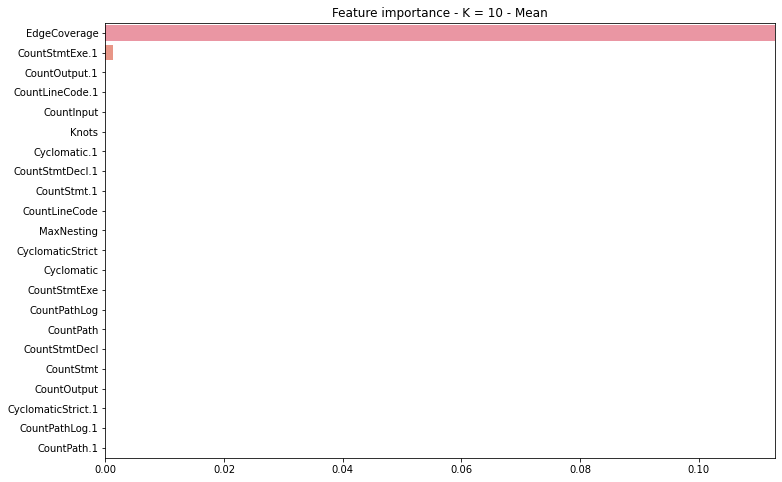

,no_scaled,scaled
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN


In [24]:
evaluate(previsores, LinearRegression(positive=True), display_feature_importance=True)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
18,CountStmtExe.1,0.00614666
13,CountOutput.1,0.00033824
12,CountLineCode.1,3.58007e-06
0,CountInput,0
1,CountLineCode,0
19,Cyclomatic.1,0
17,CountPathLog.1,0
15,CountStmtDecl.1,0
14,CountStmt.1,0
11,MaxNesting,0


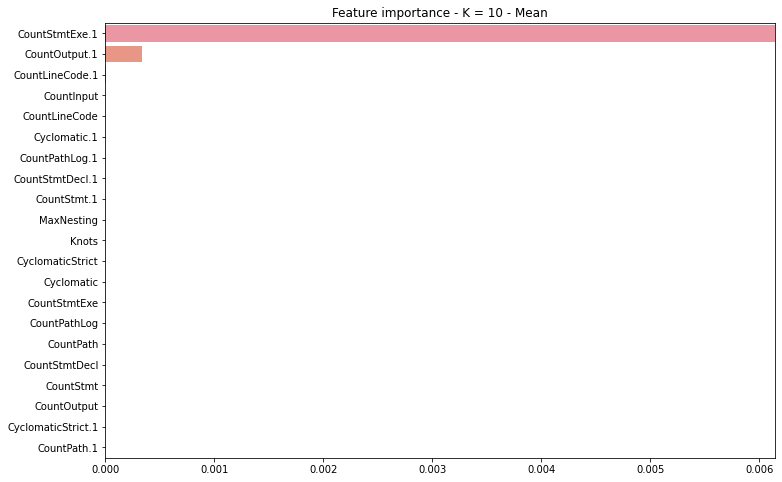

,no_scaled,scaled
Mean Abs Error,0.297273,0.297273
Mean Sqr Error,0.130122,0.130122
Mean Sqr Log Error,0.0507882,0.0507882
Mean Median Error,0.311615,0.311615
R2 Score,0.177976,0.177976


In [25]:
evaluate(previsores_sem_ec, LinearRegression(positive=True), display_feature_importance=True)

### Com EC

In [26]:
error_metrics_table = pd.DataFrame(
    index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
    columns=previsores
)

for previsor in previsores:
    print('PREVISOR ', previsor)
    metrics = evaluate([
        previsor
    ], LinearRegression(positive=True), dataset)
    error_metrics_table[previsor] = metrics['scaled']
    display(metrics)
    print('\n')

PREVISOR  CountInput


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountLineCode


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountOutput


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmt


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmtDecl


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPath


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPathLog


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmtExe


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  Cyclomatic


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CyclomaticStrict


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  Knots


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  MaxNesting


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  EdgeCoverage


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

,no_scaled,scaled
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN




PREVISOR  CountLineCode.1


,no_scaled,scaled
Mean Abs Error,0.294229,0.294229
Mean Sqr Error,0.113319,0.113319
Mean Sqr Log Error,0.0494709,0.0494709
Mean Median Error,0.307604,0.307604
R2 Score,0.0317703,0.0317703




PREVISOR  CountOutput.1


,no_scaled,scaled
Mean Abs Error,0.294844,0.294844
Mean Sqr Error,0.114245,0.114245
Mean Sqr Log Error,0.0499953,0.0499953
Mean Median Error,0.307665,0.307665
R2 Score,0.0398916,0.0398916




PREVISOR  CountStmt.1


,no_scaled,scaled
Mean Abs Error,0.294491,0.294491
Mean Sqr Error,0.113397,0.113397
Mean Sqr Log Error,0.0494741,0.0494741
Mean Median Error,0.308865,0.308865
R2 Score,0.0299882,0.0299882




PREVISOR  CountStmtDecl.1


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPath.1


,no_scaled,scaled
Mean Abs Error,0.330616,0.330616
Mean Sqr Error,1.48944,1.48944
Mean Sqr Log Error,0.0581882,0.0581882
Mean Median Error,0.32638,0.32638
R2 Score,12.1851,12.1851




PREVISOR  CountPathLog.1


,no_scaled,scaled
Mean Abs Error,0.302088,0.302088
Mean Sqr Error,0.116794,0.116794
Mean Sqr Log Error,0.050945,0.050945
Mean Median Error,0.326448,0.326448
R2 Score,0.052479,0.052479




PREVISOR  CountStmtExe.1


,no_scaled,scaled
Mean Abs Error,0.293639,0.293639
Mean Sqr Error,0.113051,0.113051
Mean Sqr Log Error,0.0492599,0.0492599
Mean Median Error,0.311154,0.311154
R2 Score,0.0261972,0.0261972




PREVISOR  Cyclomatic.1


,no_scaled,scaled
Mean Abs Error,0.301998,0.301998
Mean Sqr Error,0.116761,0.116761
Mean Sqr Log Error,0.0509288,0.0509288
Mean Median Error,0.325733,0.325733
R2 Score,0.0521811,0.0521811




PREVISOR  CyclomaticStrict.1


,no_scaled,scaled
Mean Abs Error,0.302071,0.302071
Mean Sqr Error,0.11679,0.11679
Mean Sqr Log Error,0.0509428,0.0509428
Mean Median Error,0.326083,0.326083
R2 Score,0.0524417,0.0524417


C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Linear Regression - R2 Score'}>

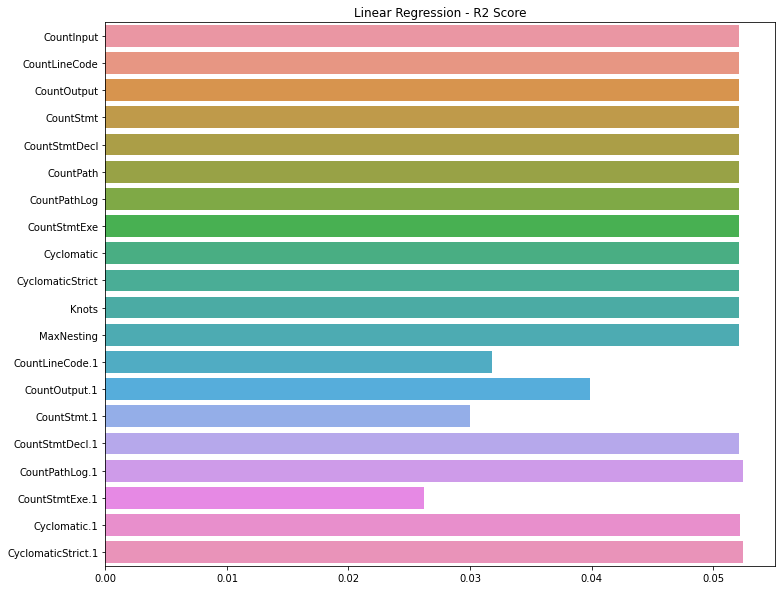

In [27]:
error_metrics = error_metrics_table.iloc[-1,:].dropna()
error_metrics = error_metrics[error_metrics < 1]
y_axis = error_metrics.values
x_axis = error_metrics.index.values
plt.figure(figsize=(12,10))
plt.title('Linear Regression - R2 Score')
sns.barplot(y_axis, x_axis)

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Linear Regression - MSE'}>

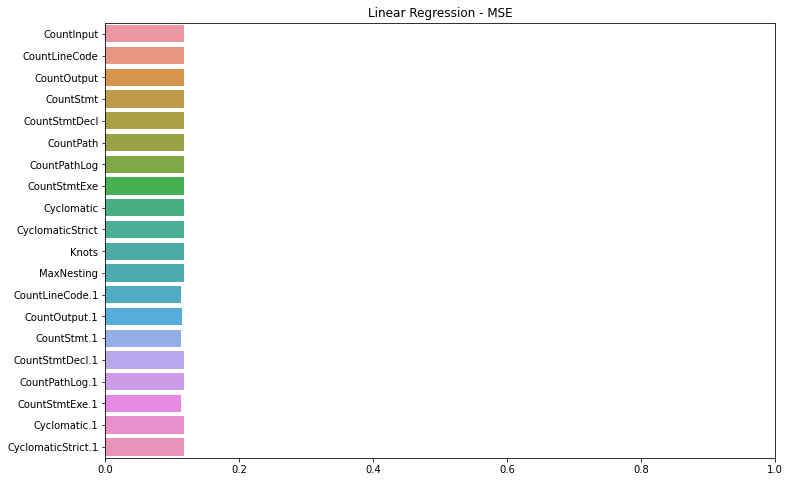

In [28]:
error_metrics = error_metrics_table.iloc[1,:].dropna()
error_metrics = error_metrics[error_metrics < 1]
y_axis = error_metrics.values
x_axis = error_metrics.index.values
plt.figure(figsize=(12,8))
plt.axis([0, 1, 0, len(x_axis)])
plt.title('Linear Regression - MSE')
sns.barplot(y_axis, x_axis)

In [29]:
evaluate([
    'EdgeCoverage'
], LinearRegression(fit_intercept=False), dataset)

,no_scaled,scaled
Mean Abs Error,0.206974,0.206974
Mean Sqr Error,0.0620772,0.0620772
Mean Sqr Log Error,0.029046,0.029046
Mean Median Error,0.212136,0.212136
R2 Score,0.441571,0.441571


In [30]:
evaluate([
    'MaxNesting'
], LinearRegression(fit_intercept=False), dataset)

,no_scaled,scaled
Mean Abs Error,0.495413,0.495413
Mean Sqr Error,0.377472,0.377472
Mean Sqr Log Error,0.178821,0.178821
Mean Median Error,0.406899,0.406899
R2 Score,2.51427,2.51427


### Sem EC

In [31]:
error_metrics_table = pd.DataFrame(
    index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
    columns=previsores
)

for previsor in previsores:
    if previsor == 'EdgeCoverage':
        continue
        
    print('PREVISOR ', previsor)
    metrics = evaluate([
        previsor
    ], LinearRegression(positive=True), dataset)
    error_metrics_table[previsor] = metrics['scaled']
    display(metrics)
    print('\n')

PREVISOR  CountInput


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountLineCode


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountOutput


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmt


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmtDecl


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPath


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPathLog


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountStmtExe


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  Cyclomatic


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CyclomaticStrict


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  Knots


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  MaxNesting


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountLineCode.1


,no_scaled,scaled
Mean Abs Error,0.294229,0.294229
Mean Sqr Error,0.113319,0.113319
Mean Sqr Log Error,0.0494709,0.0494709
Mean Median Error,0.307604,0.307604
R2 Score,0.0317703,0.0317703




PREVISOR  CountOutput.1


,no_scaled,scaled
Mean Abs Error,0.294844,0.294844
Mean Sqr Error,0.114245,0.114245
Mean Sqr Log Error,0.0499953,0.0499953
Mean Median Error,0.307665,0.307665
R2 Score,0.0398916,0.0398916




PREVISOR  CountStmt.1


,no_scaled,scaled
Mean Abs Error,0.294491,0.294491
Mean Sqr Error,0.113397,0.113397
Mean Sqr Log Error,0.0494741,0.0494741
Mean Median Error,0.308865,0.308865
R2 Score,0.0299882,0.0299882




PREVISOR  CountStmtDecl.1


,no_scaled,scaled
Mean Abs Error,0.301971,0.301971
Mean Sqr Error,0.116752,0.116752
Mean Sqr Log Error,0.050924,0.050924
Mean Median Error,0.325578,0.325578
R2 Score,0.0520979,0.0520979




PREVISOR  CountPath.1


,no_scaled,scaled
Mean Abs Error,0.330616,0.330616
Mean Sqr Error,1.48944,1.48944
Mean Sqr Log Error,0.0581882,0.0581882
Mean Median Error,0.32638,0.32638
R2 Score,12.1851,12.1851




PREVISOR  CountPathLog.1


,no_scaled,scaled
Mean Abs Error,0.302088,0.302088
Mean Sqr Error,0.116794,0.116794
Mean Sqr Log Error,0.050945,0.050945
Mean Median Error,0.326448,0.326448
R2 Score,0.052479,0.052479




PREVISOR  CountStmtExe.1


,no_scaled,scaled
Mean Abs Error,0.293639,0.293639
Mean Sqr Error,0.113051,0.113051
Mean Sqr Log Error,0.0492599,0.0492599
Mean Median Error,0.311154,0.311154
R2 Score,0.0261972,0.0261972




PREVISOR  Cyclomatic.1


,no_scaled,scaled
Mean Abs Error,0.301998,0.301998
Mean Sqr Error,0.116761,0.116761
Mean Sqr Log Error,0.0509288,0.0509288
Mean Median Error,0.325733,0.325733
R2 Score,0.0521811,0.0521811




PREVISOR  CyclomaticStrict.1


,no_scaled,scaled
Mean Abs Error,0.302071,0.302071
Mean Sqr Error,0.11679,0.11679
Mean Sqr Log Error,0.0509428,0.0509428
Mean Median Error,0.326083,0.326083
R2 Score,0.0524417,0.0524417


### Apenas EC

In [32]:
evaluate([
    'EdgeCoverage'
], LinearRegression(fit_intercept=False), dataset)

,no_scaled,scaled
Mean Abs Error,0.206974,0.206974
Mean Sqr Error,0.0620772,0.0620772
Mean Sqr Log Error,0.029046,0.029046
Mean Median Error,0.212136,0.212136
R2 Score,0.441571,0.441571


## SVR

In [33]:
def evaluate_svr(metrics, epsilon = 0.1, tot_seeds=0, display_feature_importance=False):
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=[0, 'Mean']
    )
    
    error_scaled_metrics_table.index.name = 'Error metrics'
    error_scaled_metrics_table.columns.name = 'Seed'

    error_metrics = evaluate(metrics, SVR(epsilon=epsilon), dataset, apenas_escalonamento=True, display_feature_importance=display_feature_importance)
    error_scaled_metrics_table[0] = error_metrics['scaled']
    estimator_metrics_to_dataframe(error_metrics, error_scaled_metrics_table)

    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

,Metrics,Importance
12,EdgeCoverage,0.0858965
6,CountPathLog,0.00870845
11,MaxNesting,0.00430722
7,CountStmtExe,0.00382408
3,CountStmt,0.00333331
4,CountStmtDecl,0.0029799
9,CyclomaticStrict,0.00278582
15,CountStmt.1,0.00104377
19,CountStmtExe.1,0.00100108
8,Cyclomatic,0.000949374


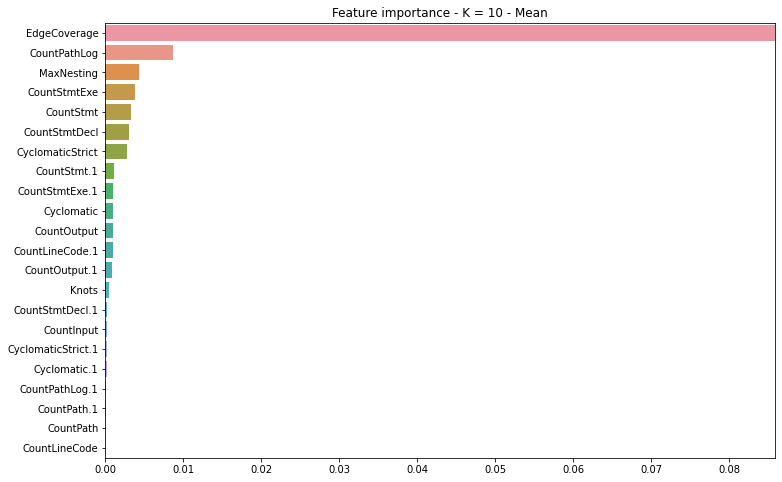

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,NaN,NaN
Mean Sqr Error,NaN,NaN
Mean Sqr Log Error,NaN,NaN
Mean Median Error,NaN,NaN
R2 Score,NaN,NaN


In [34]:
evaluate_svr(previsores, epsilon=0.3, display_feature_importance=True)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
11,MaxNesting,0.0236545
6,CountPathLog,0.0197674
8,Cyclomatic,0.0150978
7,CountStmtExe,0.00959733
1,CountLineCode,0.0067273
0,CountInput,0.00636571
13,CountOutput.1,0.00505992
14,CountStmt.1,0.00498466
18,CountStmtExe.1,0.00488976
12,CountLineCode.1,0.00439583


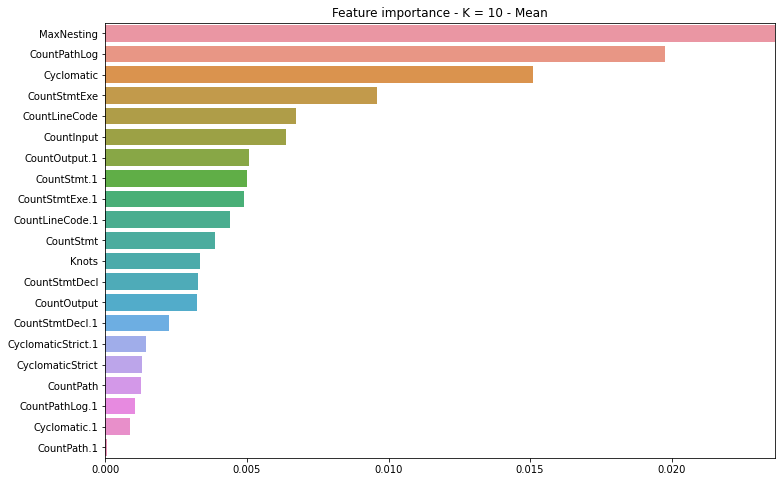

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.218093,NaN
Mean Sqr Error,0.0626579,NaN
Mean Sqr Log Error,0.0279004,NaN
Mean Median Error,0.20869,NaN
R2 Score,0.421141,NaN


In [35]:
evaluate_svr(previsores_sem_ec, epsilon=0.3, display_feature_importance=True)

### Com EC

In [36]:
evaluate_svr(previsores, epsilon=0.4)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.229429,NaN
Mean Sqr Error,0.0695661,NaN
Mean Sqr Log Error,0.0278945,NaN
Mean Median Error,0.236011,NaN
R2 Score,0.359841,NaN


In [37]:
evaluate_svr([
    'CountOutput',
    'EdgeCoverage',
    'Knots',
    'CountStmtDecl',
], epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.185766,NaN
Mean Sqr Error,0.0468584,NaN
Mean Sqr Log Error,0.0196152,NaN
Mean Median Error,0.203179,NaN
R2 Score,0.574105,NaN


In [38]:
evaluate_svr([
    'Cyclomatic', 
    'CyclomaticStrict', 
    'CountInput', 
    'CountOutput',
    'EdgeCoverage',
    'CountStmtExe.1'
], epsilon=0.4)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.218685,NaN
Mean Sqr Error,0.0622643,NaN
Mean Sqr Log Error,0.0242962,NaN
Mean Median Error,0.222261,NaN
R2 Score,0.4266,NaN


In [39]:
evaluate_svr([
    'MaxNesting', 
    'CountPath', 
    'CountStmtExe', 
    'CountInput', 
    'CountOutput',
    'CountStmtExe.1'
], epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.2157,NaN
Mean Sqr Error,0.0637464,NaN
Mean Sqr Log Error,0.0285504,NaN
Mean Median Error,0.195121,NaN
R2 Score,0.410263,NaN


In [40]:
evaluate_svr([
    'CountInput','CountOutput','CountPath','CountStmt','CountStmtDecl','Knots',
    'MaxNesting',
    
    'CountOutput.1','CountStmtDecl.1','CountStmtExe.1'
], epsilon=0.4)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.246073,NaN
Mean Sqr Error,0.0790754,NaN
Mean Sqr Log Error,0.0347405,NaN
Mean Median Error,0.245945,NaN
R2 Score,0.285856,NaN


In [41]:
evaluate_svr([
    'Cyclomatic', 
    'CountOutput',
    'EdgeCoverage'
], epsilon=0.4)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.22054,NaN
Mean Sqr Error,0.0648962,NaN
Mean Sqr Log Error,0.0252986,NaN
Mean Median Error,0.229466,NaN
R2 Score,0.403778,NaN


### Sem EC

In [42]:
evaluate_svr(previsores_sem_ec, epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.218093,NaN
Mean Sqr Error,0.0626579,NaN
Mean Sqr Log Error,0.0279004,NaN
Mean Median Error,0.20869,NaN
R2 Score,0.421141,NaN


### Apenas EC

In [43]:
evaluate_svr([
    'EdgeCoverage',
], epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error metrics,,
Mean Abs Error,0.210894,NaN
Mean Sqr Error,0.0587562,NaN
Mean Sqr Log Error,0.0238038,NaN
Mean Median Error,0.236372,NaN
R2 Score,0.459563,NaN


## Neural network

In [44]:
def evaluate_neural_network(metrics, epsilon, tot_seeds=0, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, MLPRegressor(epsilon=epsilon, random_state=i), dataset, apenas_escalonamento=True, display_feature_importance=display_feature_importance)
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

In [45]:
#evaluate_neural_network(previsores, display_feature_importance=True)

<ipython-input-21-27b9f9ca2ebf>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fi_scaled_table['Mean'][i] = fi_scaled_table.iloc[i,:-1].mean()


,Metrics,Importance
11,MaxNesting,0.0179343
6,CountPathLog,0.0126583
7,CountStmtExe,0.0027116
9,CyclomaticStrict,0.001445
10,Knots,0.00119342
3,CountStmt,0.00110103
12,CountLineCode.1,0.00103448
2,CountOutput,0.000946382
1,CountLineCode,0.00078768
14,CountStmt.1,0.00074113


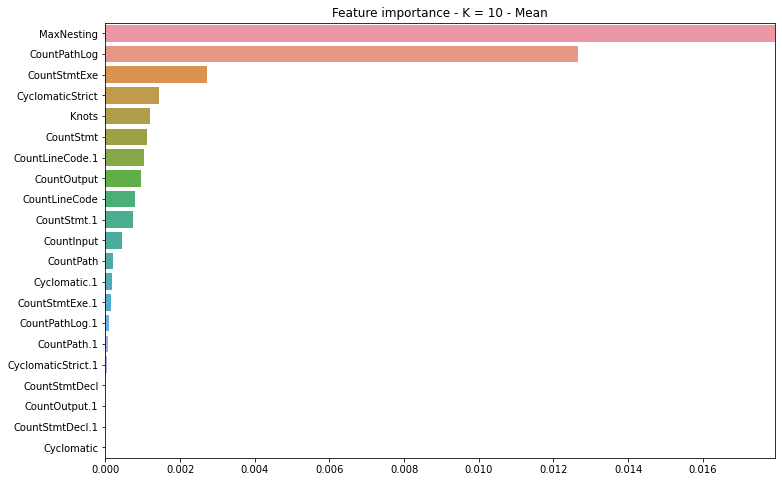

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.243107,0.243107
Mean Sqr Error,0.0774932,0.0774932
Mean Sqr Log Error,0.034324,0.034324
Mean Median Error,0.243669,0.243669
R2 Score,0.297552,0.297552


In [46]:
evaluate_neural_network(previsores_sem_ec, epsilon=0.3, display_feature_importance=True)

### Com EC

In [47]:
evaluate_neural_network(previsores, epsilon=0.8)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.233972,0.233972
Mean Sqr Error,0.0708001,0.0708001
Mean Sqr Log Error,0.0319111,0.0319111
Mean Median Error,0.239292,0.239292
R2 Score,0.373508,0.373508


### Sem EC

In [48]:
evaluate_neural_network(previsores_sem_ec, epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.243107,0.243107
Mean Sqr Error,0.0774932,0.0774932
Mean Sqr Log Error,0.034324,0.034324
Mean Median Error,0.243669,0.243669
R2 Score,0.297552,0.297552


### Apenas EC

In [49]:
evaluate_neural_network([
    'EdgeCoverage'
], epsilon=0.3)

-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.241533,0.241533
Mean Sqr Error,0.0783181,0.0783181
Mean Sqr Log Error,0.0353284,0.0353284
Mean Median Error,0.258806,0.258806
R2 Score,0.304758,0.304758


## Random forest

In [417]:
def evaluate_random_forest(metrics, tot_seeds=0, display_prediction=False, display_feature_importance=False):
    seeds = [i for i in range(tot_seeds+1)]
    seeds.append('Mean')
    error_noscaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_scaled_metrics_table = pd.DataFrame(
        index=['Mean Abs Error', 'Mean Sqr Error', 'Mean Sqr Log Error', 'Mean Median Error', 'R2 Score'],
        columns=seeds
    )
    error_noscaled_metrics_table.columns.name = 'Seed'
    error_noscaled_metrics_table.index.name = 'Error Metrics'
    error_scaled_metrics_table.columns.name = 'Seed'
    error_scaled_metrics_table.index.name = 'Error Metrics'

    for i in range(0,tot_seeds+1):
        error_metrics = evaluate(metrics, RandomForestRegressor(random_state=i), dataset, display_prediction=display_prediction, display_feature_importance=display_feature_importance)
        error_noscaled_metrics_table[i] = error_metrics['no_scaled']
        error_scaled_metrics_table[i] = error_metrics['scaled']

    estimator_metrics_to_dataframe(error_noscaled_metrics_table, error_noscaled_metrics_table)
    estimator_metrics_to_dataframe(error_scaled_metrics_table, error_scaled_metrics_table)
    
    print('-----< SEM ESCALONAMENTO >-----')
    display(error_noscaled_metrics_table)
    print('-----< COM ESCALONAMENTO >-----')
    display(error_scaled_metrics_table)

In [418]:
evaluate_random_forest(previsores, display_feature_importance=False)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.056192,0.056192
Mean Sqr Error,0.012195,0.012195
Mean Sqr Log Error,0.005912,0.005912
Mean Median Error,0.014883,0.014883
R2 Score,0.900465,0.900465


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.056463,0.056463
Mean Sqr Error,0.01226,0.01226
Mean Sqr Log Error,0.005952,0.005952
Mean Median Error,0.015691,0.015691
R2 Score,0.899955,0.899955


In [419]:
evaluate_random_forest(previsores_sem_ec, display_feature_importance=False)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.194818,0.194818
Mean Sqr Error,0.07544,0.07544
Mean Sqr Log Error,0.034897,0.034897
Mean Median Error,0.145374,0.145374
R2 Score,0.377501,0.377501


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.195093,0.195093
Mean Sqr Error,0.075554,0.075554
Mean Sqr Log Error,0.034952,0.034952
Mean Median Error,0.145843,0.145843
R2 Score,0.376707,0.376707


In [421]:
evaluate_random_forest(['EdgeCoverage'], display_feature_importance=False)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.099305,0.099305
Mean Sqr Error,0.022348,0.022348
Mean Sqr Log Error,0.010551,0.010551
Mean Median Error,0.055399,0.055399
R2 Score,0.821206,0.821206


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.099305,0.099305
Mean Sqr Error,0.022348,0.022348
Mean Sqr Log Error,0.010551,0.010551
Mean Median Error,0.055399,0.055399
R2 Score,0.821206,0.821206


### Com EC

-----< SEM ESCALONAMENTO >-----


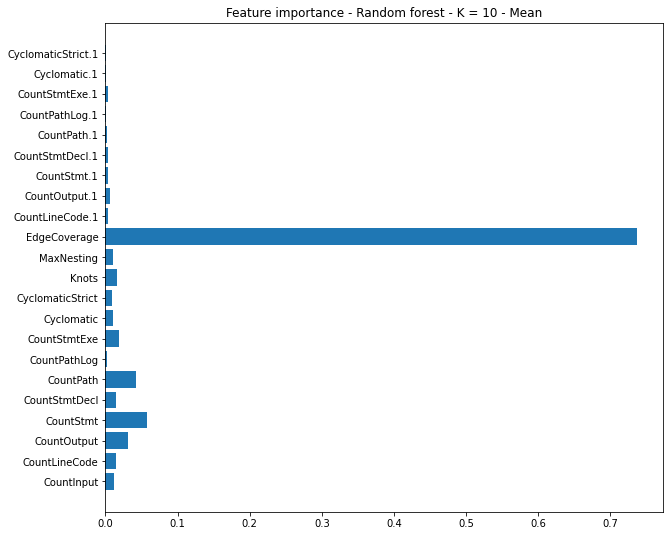



-----< COM ESCALONAMENTO >-----
EdgeCoverage          0.736387
CountStmt             0.058045
CountPath             0.042119
CountOutput           0.030383
CountStmtExe          0.018342
Knots                 0.015660
CountLineCode         0.015333
CountStmtDecl         0.015309
CountInput            0.012241
Cyclomatic            0.010972
MaxNesting            0.010257
CyclomaticStrict      0.008127
CountOutput.1         0.006296
CountStmtDecl.1       0.004145
CountLineCode.1       0.003838
CountStmtExe.1        0.003646
CountStmt.1           0.003379
CountPathLog          0.001781
CountPath.1           0.001489
CyclomaticStrict.1    0.000904
Cyclomatic.1          0.000845
CountPathLog.1        0.000500
Name: mean, dtype: float64


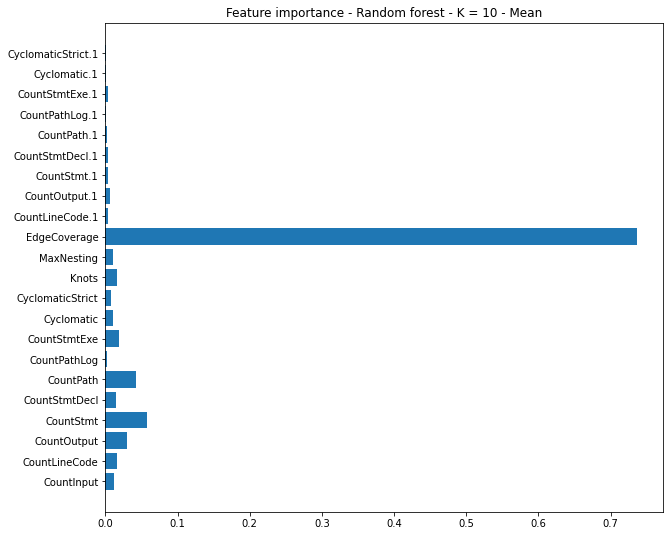

In [54]:
feature_importance(RandomForestRegressor())

In [55]:
evaluate_random_forest(previsores)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0786762,0.0786762
Mean Sqr Error,0.0188811,0.0188811
Mean Sqr Log Error,0.00903727,0.00903727
Mean Median Error,0.034867,0.034867
R2 Score,0.826749,0.826749


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0787833,0.0787833
Mean Sqr Error,0.0189386,0.0189386
Mean Sqr Log Error,0.00906076,0.00906076
Mean Median Error,0.0352914,0.0352914
R2 Score,0.82617,0.82617


In [56]:
evaluate_random_forest([
    'EdgeCoverage'
])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


In [57]:
evaluate_random_forest([
    'CountPath', 'CountStmtExe.1', 'CountInput', 'CountOutput', 'CountOutput.1', 'EdgeCoverage'
])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0876215,0.0876215
Mean Sqr Error,0.0215344,0.0215344
Mean Sqr Log Error,0.0101418,0.0101418
Mean Median Error,0.0429287,0.0429287
R2 Score,0.798505,0.798505


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.0875951,0.0875951
Mean Sqr Error,0.0215646,0.0215646
Mean Sqr Log Error,0.010159,0.010159
Mean Median Error,0.0425257,0.0425257
R2 Score,0.798199,0.798199


### Sem EC

-----< SEM ESCALONAMENTO >-----


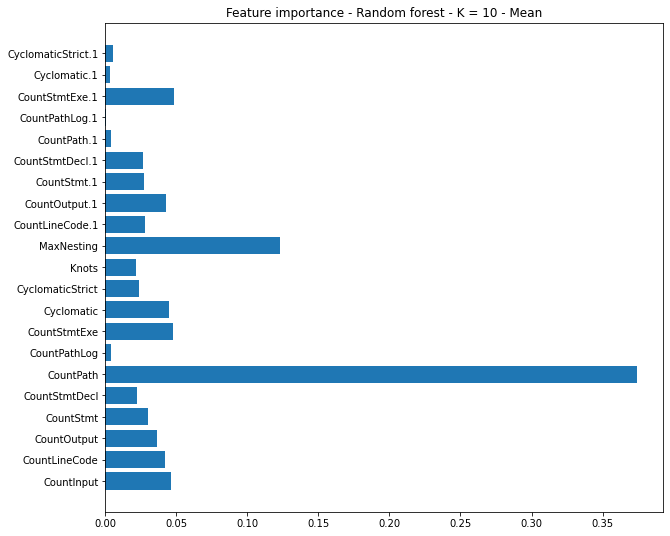



-----< COM ESCALONAMENTO >-----
CountPath             0.372770
MaxNesting            0.123629
Cyclomatic            0.048604
CountStmtExe.1        0.047891
CountInput            0.046386
CountStmtExe          0.046191
CountOutput.1         0.042582
CountLineCode         0.042388
CountOutput           0.035995
CountStmt             0.029958
CountLineCode.1       0.028381
CountStmt.1           0.026880
CountStmtDecl.1       0.026712
CountStmtDecl         0.021700
Knots                 0.021628
CyclomaticStrict      0.021458
CyclomaticStrict.1    0.005642
CountPathLog          0.004337
CountPath.1           0.003437
Cyclomatic.1          0.002767
CountPathLog.1        0.000663
Name: mean, dtype: float64


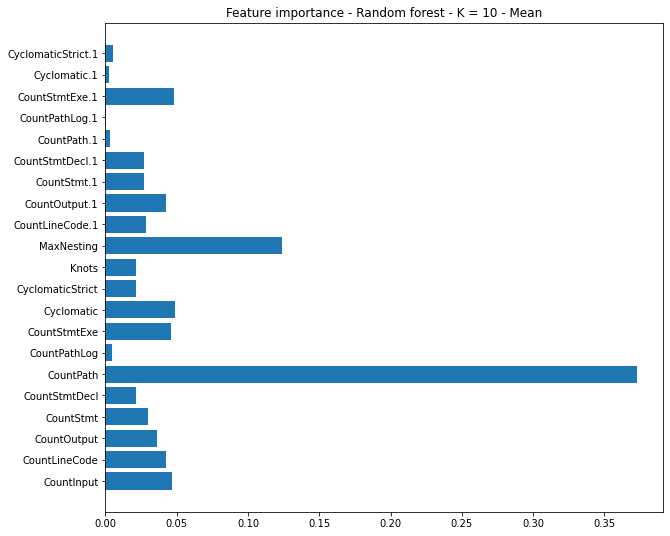

In [58]:
feature_importance(RandomForestRegressor(), prev=previsores_sem_ec)

In [59]:
evaluate_random_forest(previsores_sem_ec)

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147809,0.147809
Mean Sqr Error,0.0481227,0.0481227
Mean Sqr Log Error,0.0219381,0.0219381
Mean Median Error,0.109017,0.109017
R2 Score,0.542421,0.542421


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.147786,0.147786
Mean Sqr Error,0.0482513,0.0482513
Mean Sqr Log Error,0.021994,0.021994
Mean Median Error,0.107399,0.107399
R2 Score,0.541412,0.541412


### Apenas EC

In [60]:
evaluate_random_forest([
    'EdgeCoverage'
])

-----< SEM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531


-----< COM ESCALONAMENTO >-----


Seed,0,Mean
Error Metrics,,
Mean Abs Error,0.120745,0.120745
Mean Sqr Error,0.0303291,0.0303291
Mean Sqr Log Error,0.0142042,0.0142042
Mean Median Error,0.0740908,0.0740908
R2 Score,0.723531,0.723531
